# Textual Stats

## Artemis: Text -- Emotions

In [48]:
import nltk
import numpy
import pathlib
import pandas
import string

from tqdm import tqdm
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

from typing import Any, Dict, Iterable, List, Optional, Union

# ROOT = pathlib.Path.cwd().parent
# artemis = pandas.read_csv(
#     ROOT / "DATA" / "artemis" / "artemis_dataset_release_v0.csv"
# )
ROOT = pathlib.Path('/mnt/HDD/DATA')
artemis = pandas.read_csv(ROOT / "ARTEMIS" / "artemis_official_data" /
                          "official_data" / "artemis_dataset_release_v0.csv")
artemis['utterance'] = artemis['utterance'].apply(str.lower)
artemis['utterance'] = artemis['utterance'].apply(
    lambda s: s.translate(str.maketrans('', '', string.punctuation))
)
artemis

,art_style,painting,emotion,utterance,repetition
0,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,something else,she seems very happy in the picture and you wa...,10
1,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,sadness,this woman has really knotty hands which makes...,10
2,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,something else,when looking at this woman i am filled with cu...,10
3,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,contentment,a woman looking at ease peaceful and satisfied...,10
4,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,awe,she looks like a lady from that past that migh...,10
...,...,...,...,...,...
454679,Cubism,gino-severini_a-dancer-1,awe,the collection and collage of different colors...,48
454680,Romanticism,ivan-aivazovsky_sea-at-night-1861,awe,the peaceful reflections of the moonlight on t...,8
454681,Romanticism,ivan-aivazovsky_sea-at-night-1861,excitement,i can imagine the sailors resting this peacefu...,8
454682,Romanticism,ivan-aivazovsky_sea-at-night-1861,contentment,the steep mountains and the moonlight provide ...,8


### Characterization of language per emotion

In [56]:
def tf(documents: Union[str, List[str], pandas.Series],
	   top_k: Optional[int] = None,
	   exclude: List = None) -> Dict[str, str]:
	""" Estimate the frequency of the terms in a set of documents. Words are
	 obtained splitting sentences by whitespaces.

	 Args:
	 	documents: Texts to consider.
	 	top_k: Top terms most represented.
	 	exclude: Words to exclude from count.

	Returns:
		words and their absolute frequency.
	"""
	if not isinstance(documents, str):
		documents = ' '.join(documents)
	words = documents.split(' ')
	if exclude is not None:
		words = [w for w in words if w not in exclude]
	return {x[0]: x[1] for x in Counter(words).most_common(top_k)}

def tf_idf(documents: Dict[int, str],
		   top_k: int,
		   exclude: Union[str, List] = 'english',
		   ) -> Dict[int, List[Union[list, Any]]]:
	"""
	Retrieve the top_k most characteristic words in every document according to
	a TF-IDF measure.

	Args:
		documents (Dict[int, str]):
		top_k (int): Number of relevant words per document.
		exclude: Terms to exclude from analysis.

	Returns:
		Dict[int, List[Union[list, Any]]]
	"""
	docs = [' '.join(val) for key, val in documents.items()]
	keys = list(documents.keys())
	vectorizer = TfidfVectorizer(strip_accents='unicode',
								 lowercase=True,
								 stop_words=exclude)
	vec_docs = vectorizer.fit_transform(docs)
	feature_names = vectorizer.get_feature_names_out()
	relevant_words = dict()
	for i in tqdm(range(vec_docs.shape[0])):
		row = vec_docs.getrow(i).toarray()[0]
		k_words = numpy.flip(list(numpy.argsort(row)[-top_k:]))
		relevant_words[keys[i]] = [feature_names[j] for j in k_words]
	return relevant_words


stopwords = nltk.corpus.stopwords.words('english') + [''] + ['like', 'feel',
															 'painting',
															 'look',
															 'looks',
															 'looking',
															 'makes',
															 'colors']

emotion_labels = artemis['emotion'].unique()
utts_by_emotion = dict()
for l, label in enumerate(emotion_labels):
	artemis_l = artemis[artemis['emotion'] == label]
	utts_by_emotion[label] = artemis_l['utterance'].values
	print(f"Label: {label}")
	print(f"  > {len(artemis_l) / len(artemis):.2f}% ({len(artemis_l)})")
	most_freq_words = tf(documents=artemis_l['utterance'], top_k=10,
						 exclude=stopwords)
	print(f"  > Most common words: {most_freq_words}")
	print('-' * 79)

most_rep_words = tf_idf(documents=utts_by_emotion, top_k=10, exclude=stopwords)
print(f"  > Most representative words per emotion: {most_rep_words}")


Label: something else
  > 0.12% (52962)
  > Most common words: {'picture': 3280, 'dont': 3246, 'man': 3230, 'confused': 2982, 'im': 2721, 'seems': 2715, 'make': 2678, 'woman': 2650, 'color': 2467, 'face': 2185}
-------------------------------------------------------------------------------
Label: sadness
  > 0.11% (49061)
  > Most common words: {'sad': 13616, 'man': 6033, 'woman': 5490, 'dark': 4597, 'face': 3867, 'people': 3538, 'seems': 3529, 'sadness': 3367, 'make': 2484, 'eyes': 2290}
-------------------------------------------------------------------------------
Label: contentment
  > 0.28% (126134)
  > Most common words: {'peaceful': 9571, 'woman': 8684, 'scene': 8228, 'calm': 7770, 'blue': 7168, 'water': 6779, 'nice': 6770, 'beautiful': 6758, 'content': 6435, 'make': 6356}
-------------------------------------------------------------------------------
Label: awe
  > 0.16% (72927)
  > Most common words: {'beautiful': 6444, 'love': 5174, 'man': 4384, 'detail': 4368, 'awe': 4347, '

100%|██████████| 9/9 [00:00<00:00, 663.78it/s]

  > Most representative words per emotion: {'something else': ['picture', 'dont', 'man', 'confused', 'im', 'seems', 'make', 'woman', 'color', 'face'], 'sadness': ['sad', 'man', 'woman', 'dark', 'face', 'people', 'seems', 'sadness', 'make', 'eyes'], 'contentment': ['peaceful', 'woman', 'scene', 'calm', 'blue', 'water', 'nice', 'beautiful', 'content', 'make'], 'awe': ['beautiful', 'love', 'man', 'detail', 'awe', 'woman', 'white', 'sky', 'people', 'make'], 'amusement': ['man', 'funny', 'face', 'woman', 'amusing', 'seems', 'people', 'fun', 'make', 'bright'], 'excitement': ['bright', 'exciting', 'excited', 'woman', 'love', 'people', 'make', 'beautiful', 'man', 'red'], 'fear': ['dark', 'man', 'scary', 'face', 'people', 'something', 'fear', 'woman', 'black', 'seems'], 'disgust': ['man', 'woman', 'dont', 'face', 'make', 'color', 'seems', 'people', 'naked', 'disgusting'], 'anger': ['angry', 'man', 'anger', 'red', 'face', 'woman', 'people', 'art', 'seems', 'make']}


## Artemis: Text -> Style

In [61]:
style_labels = artemis['art_style'].unique()
utts_by_style = dict()
for l, label in enumerate(style_labels):
	artemis_l = artemis[artemis['art_style'] == label]
	utts_by_style[label] = artemis_l['utterance'].values
	print(f"Label: {label}")
	print(f"  > {len(artemis_l) / len(artemis):.2f}% ({len(artemis_l)})")
	most_freq_words = tf(documents=artemis_l['utterance'], top_k=5,
						 exclude=stopwords)
	print(f"  > Most common words: {most_freq_words}")
	print('-' * 79)

most_rep_words = tf_idf(documents=utts_by_style, top_k=5, exclude=stopwords)

print("Most representative words per style:")
for style in style_labels:
	print(f"  > Style = {style}")
	print(f"    {most_rep_words[style]}")

Label: Post_Impressionism
  > 0.08% (36374)
  > Most common words: {'woman': 2301, 'make': 2130, 'scene': 1890, 'flowers': 1834, 'people': 1800}
-------------------------------------------------------------------------------
Label: Expressionism
  > 0.09% (38717)
  > Most common words: {'face': 3357, 'woman': 3341, 'man': 3164, 'make': 2123, 'dark': 2013}
-------------------------------------------------------------------------------
Label: Impressionism
  > 0.16% (72361)
  > Most common words: {'woman': 5570, 'water': 5402, 'beautiful': 4112, 'scene': 4086, 'blue': 3809}
-------------------------------------------------------------------------------
Label: Northern_Renaissance
  > 0.03% (14160)
  > Most common words: {'man': 2118, 'woman': 1224, 'people': 1150, 'seems': 928, 'face': 906}
-------------------------------------------------------------------------------
Label: Realism
  > 0.13% (59681)
  > Most common words: {'man': 6078, 'woman': 4501, 'dark': 3926, 'seems': 3460, 'face'

100%|██████████| 27/27 [00:00<00:00, 761.20it/s]

Most representative words per style:
  > Style = Post_Impressionism
    ['woman', 'make', 'flowers', 'scene', 'people']
  > Style = Expressionism
    ['face', 'woman', 'man', 'make', 'dark']
  > Style = Impressionism
    ['water', 'woman', 'beautiful', 'scene', 'sky']
  > Style = Northern_Renaissance
    ['man', 'woman', 'people', 'seems', 'face']
  > Style = Realism
    ['man', 'woman', 'dark', 'seems', 'face']
  > Style = Romanticism
    ['man', 'woman', 'people', 'dark', 'seems']
  > Style = Symbolism
    ['mountains', 'man', 'woman', 'blue', 'dark']
  > Style = Art_Nouveau_Modern
    ['woman', 'man', 'face', 'seems', 'make']
  > Style = Naive_Art_Primitivism
    ['man', 'people', 'woman', 'bright', 'make']
  > Style = Baroque
    ['man', 'people', 'woman', 'face', 'dark']
  > Style = Rococo
    ['man', 'woman', 'face', 'people', 'seems']
  > Style = Abstract_Expressionism
    ['red', 'shapes', 'black', 'color', 'make']
  > Style = Cubism
    ['shapes', 'make', 'abstract', 'face', '

## Does text in Artpedia behave like artistic language?

In [62]:
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

class VaderAnalysis:

	def __init__(self):
		self.vader = SentimentIntensityAnalyzer()

	def __call__(self, text):
		df = {'sentence': [], 'pos': [], 'neg': [], 'neu': [], 'compound': []}
		for sentence in text:
			sentiment_dict = self.vader.polarity_scores(sentence)
			df['sentence'].append(sentence)
			for key in sentiment_dict:
				df[key].append(sentiment_dict[key])
		df = pandas.DataFrame(df)
		return pandas.DataFrame(df)


class TextBlobAnalysis:

	def __init__(self, subjectivity=True, POS=False):
		"""
		TODO
		"""
		self.textblob = TextBlob

	def __call__(self, text):
		df = {'sentence': [], 'subjectivity': []}
		for sentence in text:
			blob = self.textblob(sentence)
			df['sentence'].append(sentence)
			df['subjectivity'].append(blob.subjectivity)
		return pandas.DataFrame(df)


class BrysbaertConcreteness:

	def __init__(self, path_to_file):
		"""
		TODO
		"""
		self.df = pandas.read_csv(path_to_file, sep='\t')
		self.gram_extractor = TextBlob

	def __call__(self, text):
		df = {'sentence': [], 'concreteness': []}
		for sentence in tqdm(text, total=len(text)):
			sentence_score = []
			df['sentence'].append(sentence)

			bi_grams = self.gram_extractor(sentence).ngrams(n=2)
			for bi_gram in bi_grams:
				idx = self._find_match(bi_gram, bigram=True)
				if idx is not None:
					sentence_score.append(self.df['Conc.M'].loc[idx])
					sentence = sentence.replace(self.df['Word'].loc[idx], '')
			words = sentence.split()
			for word in words:
				idx = self._find_match(word)
				if idx is not None:
					sentence_score.append(self.df['Conc.M'].loc[idx])

			sentence_score = numpy.mean(sentence_score) if sentence_score else None
			df['concreteness'].append(sentence_score)

		return pandas.DataFrame(df)

	def _find_match(self, word, bigram=False):
		"""
		TODO
		"""
		if bigram:
			word = ' '.join(word)
		match = self.df[self.df['Word'] == word]
		if not match.empty:
			return match.index[0]
		return None


In [67]:
artpedia_root = pathlib.Path('/mnt/HDD/DATA/Artpedia/artpedia.json')
artpedia = pandas.read_json(artpedia_root, orient='index')
artpedia

,title,img_url,year,visual_sentences,contextual_sentences,split
2,Maestà (Cimabue),https://upload.wikimedia.org/wikipedia/commons...,1280,[It is also stylistically earlier to that work...,[The Maestà is a painting by the Italian artis...,train
3,Rucellai Madonna,https://upload.wikimedia.org/wikipedia/commons...,1280,[The painting depicts the Virgin and Child ent...,[The Rucellai Madonna is a panel painting by t...,train
23,Badia Polyptych,https://upload.wikimedia.org/wikipedia/commons...,1300,[The work is composed by five framed paintings...,[The Badia Polyptych (Italian: Polittico di Ba...,train
27,Madonna with Child and six Angels (Duccio),https://upload.wikimedia.org/wikipedia/commons...,1300,[Madonna with Child and six Angels is a Madonn...,"[It was painted between 1300 and 1305, (temper...",train
30,Maestà (Duccio),https://upload.wikimedia.org/wikipedia/commons...,1300,[The front panels make up a large enthroned Ma...,"[The Maestà, or Maestà of Duccio is an altarpi...",train
...,...,...,...,...,...,...
17590,Her Majesty Queen Elizabeth II – An 80th Birth...,https://upload.wikimedia.org/wikipedia/en/d/da...,2005,"[Her Majesty Queen Elizabeth II –, An 80th Bir...",[It was unveiled at the Queen's Gallery in Buc...,val
17591,Napoleon Leading the Army Over the Alps (Kehin...,https://upload.wikimedia.org/wikipedia/commons...,2005,[Napoleon Leading the Army over the Alps is an...,[It is based on Jacques-Louis David’s 1801 equ...,train
17597,Bigger Trees Near Warter,https://upload.wikimedia.org/wikipedia/en/3/34...,2007,"[Bigger Trees Near Warter or ou Peinture en, -...","[Plein Air pour l'age Post, Measuring 460 by 1...",train
17599,Hunter's Room,https://upload.wikimedia.org/wikipedia/en/0/04...,2007,[It depicts a group of people carrying crossbo...,[Hunter's Room (German: Jagdzimmer) is a 2007 ...,test


### Sentiment

<AxesSubplot: >

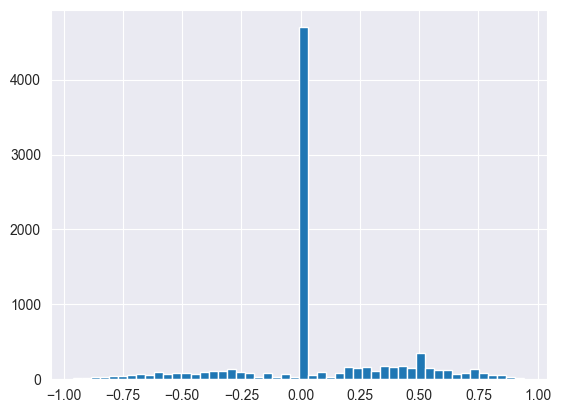

In [79]:
content_text = [s for sent in artpedia['visual_sentences'] for s in sent]

vader = VaderAnalysis()
sentiment = vader(content_text)
sentiment['compound'].hist(bins=50)

<AxesSubplot: >

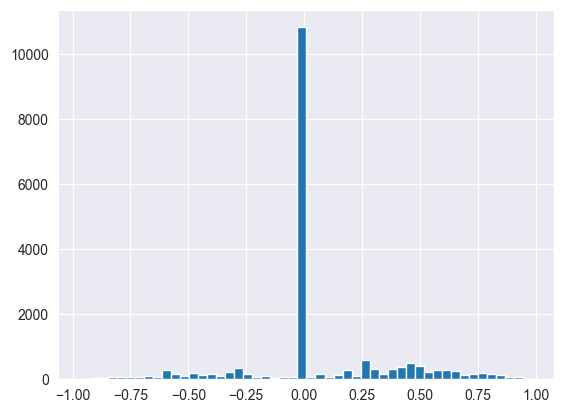

In [80]:
context_text = [s for sent in artpedia['contextual_sentences'] for s in sent]
sentiment = vader(context_text)
sentiment['compound'].hist(bins=50)

### Subjectivity

array([[<AxesSubplot: title={'center': 'subjectivity'}>]], dtype=object)

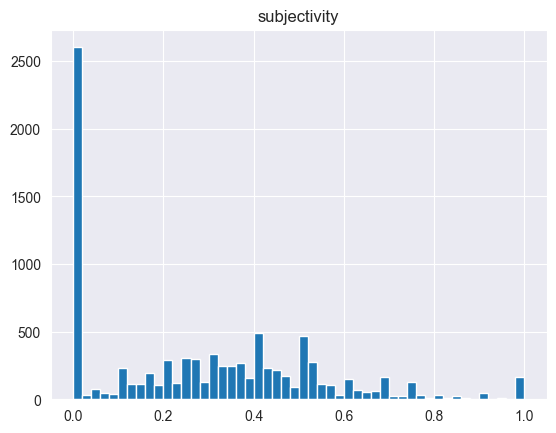

In [81]:
blob = TextBlobAnalysis()
subjectivity = blob(content_text)
subjectivity.hist(bins=50)

array([[<AxesSubplot: title={'center': 'subjectivity'}>]], dtype=object)

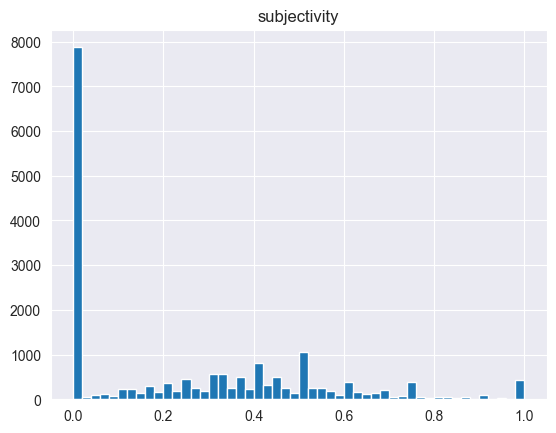

In [82]:
blob = TextBlobAnalysis()
subjectivity = blob(context_text)
subjectivity.hist(bins=50)

### Concreteness

100%|██████████| 9173/9173 [14:10<00:00, 10.79it/s]


array([[<AxesSubplot: title={'center': 'concreteness'}>]], dtype=object)

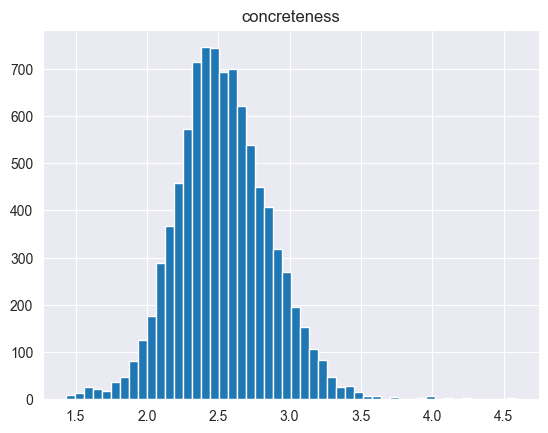

In [83]:
brys = BrysbaertConcreteness('./Brysbaert_concreteness_vocabulary.csv')
concreteness = brys(content_text)
concreteness.hist(bins=50)

100%|██████████| 19039/19039 [27:19<00:00, 11.61it/s]


array([[<AxesSubplot: title={'center': 'concreteness'}>]], dtype=object)

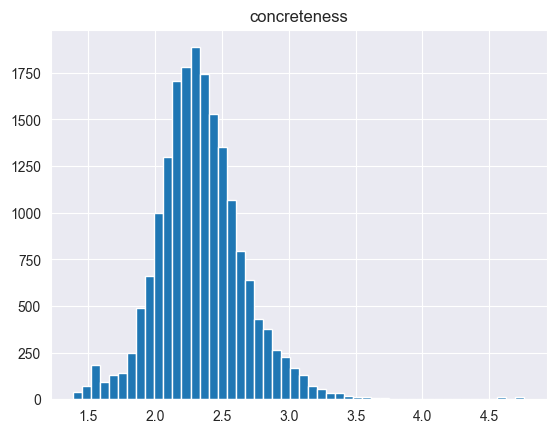

In [84]:
brys = BrysbaertConcreteness('./Brysbaert_concreteness_vocabulary.csv')
concreteness = brys(context_text)
concreteness.hist(bins=50)